In [1]:
 #!pip install interpret
 #!pip install --user xgboost
 #!pip install pytorch-tabnet
 #!pip install EMP-PY
 #!pip uninstall lightgbm -y
 #!pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
from sklearn import metrics
import time, datetime
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
dataset_folder = 'datasets/IBM Sample Dataset/'
file = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
# cannot use heldout, don't have labels
class_names = [0, 1]
_class = 'Churn'



In [4]:
df = pd.read_csv(dataset_folder + file)
# df.replace(('Yes', 'No'), (1, 0), inplace=True)
# Check duplicated values
print(df.duplicated().sum())
df.drop(['customerID'], axis=1, inplace=True)
df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object

# Missing Values

In [6]:
# Check null values
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# Check unique values in each column
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"Unique Values of {col} Column:")
    print(unique_vals)
    print()

Unique Values of gender Column:
['Female' 'Male']

Unique Values of SeniorCitizen Column:
[0 1]

Unique Values of Partner Column:
['Yes' 'No']

Unique Values of Dependents Column:
['No' 'Yes']

Unique Values of tenure Column:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique Values of PhoneService Column:
['No' 'Yes']

Unique Values of MultipleLines Column:
['No phone service' 'No' 'Yes']

Unique Values of InternetService Column:
['DSL' 'Fiber optic' 'No']

Unique Values of OnlineSecurity Column:
['No' 'Yes' 'No internet service']

Unique Values of OnlineBackup Column:
['Yes' 'No' 'No internet service']

Unique Values of DeviceProtection Column:
['No' 'Yes' 'No internet service']

Unique Values of TechSupport Column:
['No' 'Yes' 'No internet service']

Unique Values of StreamingTV Column:
['No' 'Yes' 'No in

In [8]:
# Check our target column
df[_class].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## Preprocessing Data

In [10]:
# List the columns that contain "No internet service" to convert this value to "No"
tobe_cleaned_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df[tobe_cleaned_cols] = df[tobe_cleaned_cols].replace('No internet service', 'No')
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

In [11]:
# Convert the datatype of the TotalCharge column to be float
# it seems that this column contains an empty string, so we need to deal with it before converting 
df['TotalCharges'] = df['TotalCharges'].replace(" ", "0")

# Now we can convert it
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [12]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

In [13]:
def remove_missing_values(df):
    for x in df.columns:
        if df[x].isnull().sum() != 0:
            print(x, df[x].isnull().sum())
    
    return df.dropna()
    

df = remove_missing_values(df).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int32  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int32  
 3   Dependents        7043 non-null   int32  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int32  
 6   MultipleLines     7043 non-null   int32  
 7   InternetService   7043 non-null   int32  
 8   OnlineSecurity    7043 non-null   int32  
 9   OnlineBackup      7043 non-null   int32  
 10  DeviceProtection  7043 non-null   int32  
 11  TechSupport       7043 non-null   int32  
 12  StreamingTV       7043 non-null   int32  
 13  StreamingMovies   7043 non-null   int32  
 14  Contract          7043 non-null   int32  
 15  PaperlessBilling  7043 non-null   int32  
 16  PaymentMethod     7043 non-null   int32  


In [14]:
# List of categoricals

def list_categoricals(df):
    categoricals = list()
    for x in df.columns:
        if df[x].dtype == 'object':
            categoricals.append(x)
    display(df[categoricals].nunique())
    return categoricals

categoricals = list_categoricals(df)


Series([], dtype: float64)

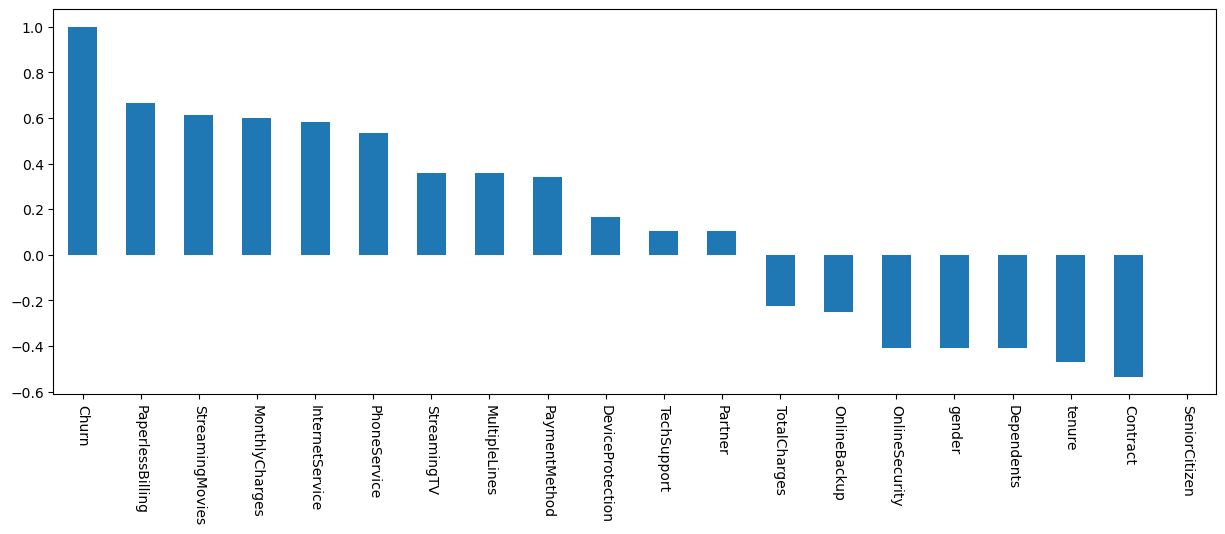

In [15]:
numericals = [x for x in df.columns if x not in categoricals]

plt.figure(figsize=(15,5))
plt.grid(True)
df[numericals].head(10).corr()[_class].sort_values(ascending = False).plot(kind='bar')
plt.xticks(rotation=-90)
plt.show()

In [16]:
df.shape

(7043, 20)

In [17]:
# Categoricals

In [18]:
df = pd.get_dummies(df, drop_first=True)

# Calculate customer value [Estimated by Atif]
df['customer_value'] = df['MonthlyCharges'] * df['tenure'].apply(lambda x: x+1) # plus 1 month in tenure


tenure_column = 'tenure' 

In [19]:
df[['MonthlyCharges', 'tenure', 'customer_value']].sort_values(by=['customer_value'], ascending=True).head(n=15)

# these are all monthly charges

,MonthlyCharges,tenure,customer_value
5218,19.70,0,19.70
3331,19.85,0,19.85
4380,20.00,0,20.00
753,20.25,0,20.25
3826,25.35,0,25.35
1082,25.75,0,25.75
1654,18.80,1,37.60
1151,18.85,1,37.70
6489,18.85,1,37.70
4939,18.90,1,37.80


In [20]:
df.shape

(7043, 21)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int32  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int32  
 3   Dependents        7043 non-null   int32  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int32  
 6   MultipleLines     7043 non-null   int32  
 7   InternetService   7043 non-null   int32  
 8   OnlineSecurity    7043 non-null   int32  
 9   OnlineBackup      7043 non-null   int32  
 10  DeviceProtection  7043 non-null   int32  
 11  TechSupport       7043 non-null   int32  
 12  StreamingTV       7043 non-null   int32  
 13  StreamingMovies   7043 non-null   int32  
 14  Contract          7043 non-null   int32  
 15  PaperlessBilling  7043 non-null   int32  
 16  PaymentMethod     7043 non-null   int32  


In [22]:
X, y = df.drop(columns=[_class]), df[_class]

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [24]:
x_test.shape

(2113, 20)

# Feature Selection

In [26]:
# from sklearn.linear_model import LassoCV

# lasso = LassoCV(tol=0.0001).fit(x_train, y_train)
# importance = np.abs(lasso.coef_)
# print(len([x for x in importance if x != 0]))

In [27]:
# from sklearn.feature_selection import SelectFromModel
# sfm = SelectFromModel(lasso).fit(x_train, y_train)

# selected_feat = x_train.columns[(sfm.get_support())]
# print(selected_feat)

# x_train = sfm.transform(x_train)
# x_test = sfm.transform(x_test)

In [28]:
# x_train = pd.DataFrame(x_train, columns=selected_feat)
# x_train.index = y_train.index
# x_test = pd.DataFrame(x_test, columns=selected_feat)
# x_test.index = y_test.index

In [29]:
# y_test

In [30]:
x_train.shape

(4930, 20)

# EDA

In [32]:
# data = x_train
# corr = data.corr()
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))
# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
# ax = sns.heatmap(
#     corr, mask=mask,
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True,  cbar_kws={"shrink": .5}
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [33]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4930 entries, 1695 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4930 non-null   int32  
 1   SeniorCitizen     4930 non-null   int64  
 2   Partner           4930 non-null   int32  
 3   Dependents        4930 non-null   int32  
 4   tenure            4930 non-null   int64  
 5   PhoneService      4930 non-null   int32  
 6   MultipleLines     4930 non-null   int32  
 7   InternetService   4930 non-null   int32  
 8   OnlineSecurity    4930 non-null   int32  
 9   OnlineBackup      4930 non-null   int32  
 10  DeviceProtection  4930 non-null   int32  
 11  TechSupport       4930 non-null   int32  
 12  StreamingTV       4930 non-null   int32  
 13  StreamingMovies   4930 non-null   int32  
 14  Contract          4930 non-null   int32  
 15  PaperlessBilling  4930 non-null   int32  
 16  PaymentMethod     4930 non-null   int32  
 17

In [34]:
# Churn distribution
# plt.figure(figsize=(6, 4))
# sns.countplot(x='churn', data=y_test.to_frame(), palette='viridis')
# plt.title('Churn Distribution')
# plt.xlabel('Churn')
# plt.ylabel('Count')
# plt.show()

# ML Model

In [36]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [38]:
random_state=42

In [39]:
x_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_value
1695,1,0,1,1,54,1,1,0,0,1,0,1,1,0,1,1,2,70.70,3770.00,3888.50
1095,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,2,80.55,80.55,161.10
3889,1,0,0,0,13,1,0,2,0,0,0,0,0,0,1,0,1,19.30,259.65,270.20
3667,0,1,1,1,24,1,0,1,0,0,1,0,1,1,2,1,2,96.55,2263.45,2413.75
2902,0,1,0,0,6,1,0,1,1,0,0,0,0,0,0,1,2,74.10,450.90,518.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,0,1,0,1,1,0,1,1,0,0,0,1,1,0,1,2,95.00,95.00,190.00
5191,0,0,1,1,23,1,1,0,1,1,1,1,1,1,2,1,1,91.10,2198.30,2186.40
5226,1,0,1,1,12,1,0,2,0,0,0,0,0,0,0,1,2,21.15,306.05,274.95
5390,1,1,0,0,12,1,1,1,0,0,1,0,1,1,0,1,2,99.45,1200.15,1292.85


In [40]:
# Grid Search

In [41]:
!pip install catboost
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Define parameter grids for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gbc = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.3, 0.7]
}

# param_grid_tabnet = {
#     'n_d': [8, 16, 24],
#     'n_a': [8, 16, 24],
#     'n_steps': [3, 5, 7],
#     'gamma': [1.0, 1.5, 2.0]
# }

param_grid_ebm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_bins': [128, 256],
    'max_interaction_bins': [16, 32],
    'interactions': [10, 20]
}

param_grid_cbc = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5],
}

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
}

# Initialize the models
rf = RandomForestClassifier(random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
cbc = CatBoostClassifier(verbose=0, random_state=42)
lgbm = LGBMClassifier(random_state=42)
# tabnet = TabNetClassifier(verbose=0, seed=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)

In [42]:
def gridsearch_now(model, param_grid, x, y, cv, scoring, refit=True, verbose=None, _name=None):
    if refit == 'emp':
        n_jobs = 1
    else:
        n_jobs = -1
    now = datetime.datetime.now()
    if _name:
        print(_name.title(), 'at', now)
    else:
        print('At', now)
    start = time.time()
    if verbose:
        gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, n_jobs=n_jobs, verbose=verbose)
    else:
        gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, n_jobs=n_jobs)
    gs.fit(x_train, y_train)
    taken = time.time() - start
    print(f' > done; taken {taken:.2f}')
    return gs

In [43]:
clfs_with_grids = [(rf, param_grid_rf, 'rf', True), (gbc, param_grid_gbc, 'gbc', True), 
                   (_xgb, param_grid_xgb, 'xgb', True), (cbc, param_grid_cbc, 'cbc', True), 
                   (lgbm, param_grid_lgbm, 'lgbm', True),
                   (ebm, param_grid_ebm, 'ebm', True)]

## Custom Metrics

### eProfits

In [46]:
# !pip install lifelines

(4930,) (4930,)


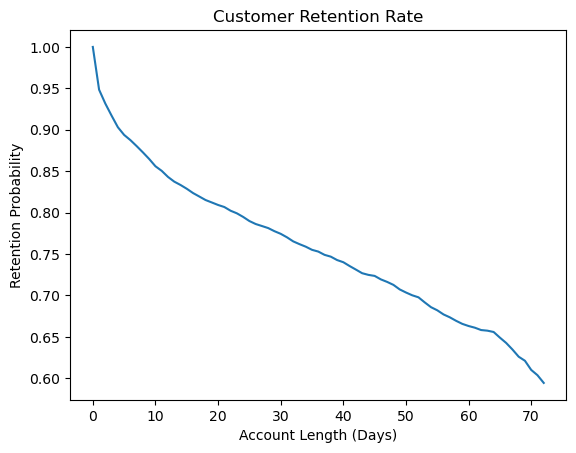

Retention rate at 32.43 days: 76.52%
0.855923398940697


'Average Retention Rate  0.77'

In [47]:
# obtain retention
from lifelines import KaplanMeierFitter

# Survival Analysis: The Kaplan-Meier estimator is used to model the time until an event (e.g., churn) and estimate the retention rate over time.

def get_retention_rate():

    tenure = x_train[tenure_column].values
    event_observed = y_train.values

    print(tenure.shape, event_observed.shape)
    
    # Kaplan-Meier Estimator
    kmf = KaplanMeierFitter()
    kmf.fit(tenure, event_observed=event_observed)
    
    # Plot the survival function
    # print(kmf.survival_function_)
    plt.plot(kmf.survival_function_)
    plt.title('Customer Retention Rate')
    plt.xlabel('Account Length (Days)')
    plt.ylabel('Retention Probability')
    plt.show()
    
    # Estimate retention rate at specific time points
    avg_tenure = tenure.mean()
    retention_rate = kmf.survival_function_at_times(avg_tenure).values[0]
    print(f'Retention rate at {avg_tenure:.2f} days: {retention_rate * 100:.2f}%')
    return retention_rate, lambda x: kmf.survival_function_at_times(x).values[0]

avg_retention_rate, retention_fn = get_retention_rate()
print(retention_fn(10))
f'Average Retention Rate {avg_retention_rate: .2f}'

In [48]:
def estimate_clv_and_cost_of_intervention(df, i, Profit_Margin=0.3, CPO = 0.1):
    # Estimate of Customer Life Time Value: [(CV_daily * 30) * Profit Margin/ ((1 - retention_rate))]
    monthly_revenue = df.iloc[i]['customer_value']
    retention_rate = min(0.995, df.iloc[i]['retention_rate']) # retention rate can never be 1
    clv = (monthly_revenue * Profit_Margin) / (1 - retention_rate)
    
    # Example: Cost of intervention is 10% of CLV adjusted by account length
    base_cost = CPO * clv
    # adjustment_factor = 1 + (df.iloc[i]['accountlength'] / 100)  # Example adjustment
    # cost_per_offer = base_cost * adjustment_factor
    cost_per_offer = base_cost
    return clv, cost_per_offer
    
# Our Metric calculation function
def _eprofits(df, Profit_Margin, Cost_of_Contact, CPO, verbose=0):
    profits = []
    for i in range(len(df)):
        clv, cost_per_offer = estimate_clv_and_cost_of_intervention(df, i, Profit_Margin, CPO)
        cost_of_contact = max(Cost_of_Contact[0], Cost_of_Contact[1]*cost_per_offer)
        if df.iloc[i]['true'] == 1 and df.iloc[i]['predict'] == df.iloc[i]['true']:   # chruners predicted as churners
            profit = clv - cost_per_offer - cost_of_contact
            if verbose:
                print(profit, i, df.iloc[i]['true'], df.iloc[i]['predict'])
        elif df.iloc[i]['predict'] == 1:  # not chruners predicted as churners
            profit = -cost_per_offer - cost_of_contact
                if verbose:
                print(profit, i, df.iloc[i]['true'], df.iloc[i]['predict'])
        # elif df.iloc[i]['true'] == 1:  # chruners but not predicted as churners
        #     profit = -clv
        #     if verbose:
        #         print(profit, i, df.iloc[i]['true'], df.iloc[i]['predict'])
        else:
            profit = 0 # not churners and not predicted as churners
        profits.append(profit)
    return sum(profits)

In [49]:
Profit_Margin = 0.3
Cost_of_Contact = (0, 0.3)
CPO = 0.1

def custom_eprofits_function(df, Profit_Margin, Cost_of_Contact, CPO):
    def custom_scorer(y_true, y_pred):
        my_df = df.loc[y_true.index]
        my_df['true'] = y_true
        my_df['predict'] = y_pred
        return _eprofits(my_df, Profit_Margin, Cost_of_Contact, CPO)
    return metrics.make_scorer(custom_scorer, greater_is_better=True)

df_eprofits_scorer_train = pd.DataFrame({'customer_value': x_train['customer_value'], 'retention_rate': x_train[tenure_column].apply(retention_fn)})
eprofits_scorer_train = custom_eprofits_function(df_eprofits_scorer_train, Profit_Margin, Cost_of_Contact, CPO)

In [50]:
from EMP.metrics import empChurn


# Define the custom scorer function
def emp_scorer(estimator, X, y):
    # Use the model to predict probabilities
    y_proba = estimator.predict_proba(X)[:, 1]  # Assuming binary classification and taking the probability of class 1
    return empChurn(y_proba, y, alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP

# Create the custom scorer using make_scorer
custom_emp_function = metrics.make_scorer(emp_scorer, greater_is_better=True, needs_proba=True)

In [51]:
# Define scoring method
# scoring = {'AUC': 'roc_auc'}
# scoring = 'accuracy'
# scoring = 'f1'


full_scoring_dict = {
    'AUC': metrics.make_scorer(metrics.roc_auc_score),
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'f1': metrics.make_scorer(metrics.f1_score),
    'emp': custom_emp_function,
    'eprofits': eprofits_scorer_train,
}

## GridSearch

In [53]:
def run_grid_search(full_scoring_dict):
    grid_search_dict = {}
    for sc_policy, scorer_fn in full_scoring_dict.items():
        _scoring = {sc_policy: scorer_fn}
        refit = sc_policy
        print('With scoring', sc_policy)
        for clf, param_grid, _name, _ in clfs_with_grids:
            if not _name in grid_search_dict:
                grid_search_dict[_name] = {}
            grid_search_dict[_name][sc_policy] = gridsearch_now(clf, param_grid, x_train, y_train, 5, _scoring, refit, verbose=1, _name=_name)
    return grid_search_dict


grid_search_dict = run_grid_search(full_scoring_dict)

With scoring AUC
Rf at 2024-11-24 22:41:24.590356
Fitting 5 folds for each of 108 candidates, totalling 540 fits
 > done; taken 180.55
Gbc at 2024-11-24 22:44:25.138901
Fitting 5 folds for each of 27 candidates, totalling 135 fits
 > done; taken 78.61
Xgb at 2024-11-24 22:45:43.753692
Fitting 5 folds for each of 54 candidates, totalling 270 fits
 > done; taken 12.39
Cbc at 2024-11-24 22:45:56.146021
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 > done; taken 11.02
Lgbm at 2024-11-24 22:46:07.164177
Fitting 5 folds for each of 8 candidates, totalling 40 fits


  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098
 > done; taken 20.54
Ebm at 2024-11-24 22:46:27.707902
Fitting 5 folds for each of 24 candidates, totalling 120 fits
 > done; taken 535.55
With scoring accuracy
Rf at 2024-11-24 22:55:23.264291
Fitting 5 folds for each of 108 candidates, totalling 540 fits
 > done; taken 318.83
Gbc at 2024-11-24 23:00:42.091192
Fitting 5 folds for each of 27 candidates, totalling 135 fits
 > done; taken 182.94
Xgb at 2024-11-24 23:03:45.034120
Fitting 5 folds

In [54]:
def show_grid_search_results(scoring_list, grid_search_dict):
    grid_results = {}
    for sc_policy in scoring_list:
        print(f'For {sc_policy}')
        for clf, param_grid, _name, _ in clfs_with_grids:
            _best = grid_search_dict[_name][sc_policy].best_estimator_
            # print(_name, _best)
            y_pred = _best.predict(x_test)
            y_prob = _best.predict_proba(x_test)[:, 1]
            if not _name in grid_results:
                grid_results[_name] = {}
            grid_results[_name][sc_policy] = {'_best': _best, 'y_pred': y_pred, 'y_prob': y_prob}
        
        for clf, param_grid, _name, _ in clfs_with_grids:
            y_prob = grid_results[_name][sc_policy]['y_prob']
            print(f' Best {_name} AUC: {metrics.roc_auc_score(y_test, y_prob)}')
    return grid_results

grid_results = show_grid_search_results(full_scoring_dict.keys(), grid_search_dict)

For AUC
 Best rf AUC: 0.8564330881404052
 Best gbc AUC: 0.8537711713792159
 Best xgb AUC: 0.8550910926820212
 Best cbc AUC: 0.85212070374672
 Best lgbm AUC: 0.8425382562096299
 Best ebm AUC: 0.8606498178599161
For accuracy
 Best rf AUC: 0.8564330881404052
 Best gbc AUC: 0.8537711713792159
 Best xgb AUC: 0.8581022339045445
 Best cbc AUC: 0.8574360472092606
 Best lgbm AUC: 0.8524761542519352
 Best ebm AUC: 0.8606498178599161
For f1
 Best rf AUC: 0.8564330881404052
 Best gbc AUC: 0.8537711713792159
 Best xgb AUC: 0.8550910926820212
 Best cbc AUC: 0.85212070374672
 Best lgbm AUC: 0.8425382562096299
 Best ebm AUC: 0.8606498178599161
For emp
 Best rf AUC: 0.8376768479464242
 Best gbc AUC: 0.8381839875207442
 Best xgb AUC: 0.8554256010396362
 Best cbc AUC: 0.8485526145988277
 Best lgbm AUC: 0.8472411833558604
 Best ebm AUC: 0.8612277079328856
For eprofits
 Best rf AUC: 0.8347166470829287
 Best gbc AUC: 0.8373253594691334
 Best xgb AUC: 0.83994708994709
 Best cbc AUC: 0.85212070374672
 Best lg

In [55]:
df_eprofits_scorer_test = pd.DataFrame({'customer_value': x_test['customer_value'], 'retention_rate': x_test[tenure_column].apply(retention_fn)})

def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    my_df = df_eprofits_scorer_test.copy(deep=True)
    my_df['true'] = y_test
    
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        y_scores = clf.predict_proba(x_te)[:, 1]
        my_df['predict'] = pred
        _eprof = _eprofits(my_df, Profit_Margin=Profit_Margin, Cost_of_Contact= Cost_of_Contact, CPO=CPO, verbose=0)
        _emp = empChurn(y_scores, y_test, alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
        f1, acc, auc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred), sklearn.metrics.roc_auc_score(y_test, pred)
        data.append([name, f1, acc, auc, _eprof, _emp])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.', 'ROC_AUC', 'eProfits', 'EMP'])
    df = df.sort_values(by=['F1'])
    return df

In [56]:
def get_models(grid_results, sc_policy):
    rf = grid_results['rf'][sc_policy]['_best']
    gbc = grid_results['gbc'][sc_policy]['_best']
    _xgb = grid_results['xgb'][sc_policy]['_best']
    cbc = grid_results['cbc'][sc_policy]['_best']
    # lgbm = grid_results['lgbm'][sc_policy]['_best']
    ebm = grid_results['ebm'][sc_policy]['_best']
    # tbn = grid_results['tbn'][sc_policy]['_best']
    # model = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
    models = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (cbc, 'cbc', True), (lgbm, 'lgbm', True), (ebm, 'ebm', True)]
    return models

In [57]:
def get_model_report_dfs(scoring_list, grid_results):
    model_report_dfs_dict = {}
    for sc_policy in scoring_list:
        print(f'By {sc_policy}')
        models = get_models(grid_results, sc_policy)
        dataset = x_train, y_train, x_test, y_test
        model_report_dfs_dict[sc_policy] = classify_report(models, dataset)
        display(model_report_dfs_dict[sc_policy])
    return model_report_dfs_dict

model_report_dfs_dict = get_model_report_dfs(full_scoring_dict.keys(), grid_results)

By AUC
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
4,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708
0,rf,0.572008,0.800284,0.703409,335472.183499,10.830588
3,cbc,0.578171,0.796971,0.707690,390115.951666,10.771056
1,gbc,0.585603,0.798391,0.712488,374946.489455,10.835839
2,xgb,0.592593,0.802177,0.716725,378300.540994,10.847529
5,ebm,0.600595,0.809276,0.721052,399407.729664,10.950925


By accuracy
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
4,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708
0,rf,0.572008,0.800284,0.703409,335472.183499,10.830588
2,xgb,0.578842,0.800284,0.707779,372115.783330,10.856566
1,gbc,0.585603,0.798391,0.712488,374946.489455,10.835839
3,cbc,0.595238,0.806910,0.717789,390453.916725,10.847824
5,ebm,0.600595,0.809276,0.721052,399407.729664,10.950925


By f1
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
4,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708
0,rf,0.572008,0.800284,0.703409,335472.183499,10.830588
3,cbc,0.578171,0.796971,0.707690,390115.951666,10.771056
1,gbc,0.585603,0.798391,0.712488,374946.489455,10.835839
2,xgb,0.592593,0.802177,0.716725,378300.540994,10.847529
5,ebm,0.600595,0.809276,0.721052,399407.729664,10.950925


By emp
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
2,xgb,0.197836,0.754378,0.552825,53260.919209,10.912726
1,gbc,0.326027,0.767156,0.591638,100745.624524,10.646028
3,cbc,0.445769,0.779934,0.637551,193024.126552,10.756680
0,rf,0.548255,0.791765,0.689369,343511.113263,10.518192
4,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708
5,ebm,0.586000,0.804070,0.712017,365990.024215,11.000833


By eprofits
[LightGBM] [Info] Number of positive: 1295, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262677 -> initscore=-1.032098
[LightGBM] [Info] Start training from score -1.032098


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
0,rf,0.541033,0.785613,0.685145,345814.736649,10.421754
4,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708
2,xgb,0.564593,0.784666,0.699789,372266.987713,10.564273
1,gbc,0.565302,0.788926,0.699982,382767.311399,10.598430
3,cbc,0.578171,0.796971,0.707690,390115.951666,10.771056
5,ebm,0.608016,0.810222,0.726072,413470.087126,10.947996


# Metrics

In [59]:
# Lift calculation function
def calculate_lift(y_true, y_scores, percentile=0.1):
    df = pd.DataFrame({'true': y_true, 'scores': y_scores})
    df = df.sort_values('scores', ascending=False)
    top_percentile = int(len(df) * percentile)
    top_df = df.head(top_percentile)
    lift = top_df['true'].sum() / top_percentile
    
    # Calculate the overall churn rate
    overall_churn_rate = df['true'].mean()
    top_decile_lift = top_df['true'].mean() / overall_churn_rate
    # When the lift value is higher than 1, it shows a higher density of churners in the top decile

    # Lift Index
    df['decile'] = pd.qcut(df['scores'].rank(method='first'), 10, labels=False) # first decile is actually the last one
    deciles_churners = df.groupby('decile')['true'].sum().to_frame()
    deciles_churners['weight'] = np.arange(0.1, 1.1, 0.1) # first decile is actually the last one
    deciles_churners['w_churners'] = deciles_churners['weight'] * deciles_churners['true']
    lift_index = deciles_churners['w_churners'].sum()/deciles_churners['true'].sum()
    
    return lift, top_decile_lift, lift_index

# Our eProfits calculation function
def calculate_eprofits(cv_series, y_true, y_scores, y_predict, retention_series, Profit_Margin=0.3, Cost_of_Contact = (0, 0.3), CPO=0.1, top_profitable_percentile=0.2):
    df = pd.DataFrame({'customer_value': cv_series, 'true': y_true, 'predict': y_predict, 'scores': y_scores, 'retention_rate': retention_series})
    df = df.sort_values(by=['customer_value', 'scores'], ascending=False)
    profits_full = _eprofits(df, Profit_Margin, Cost_of_Contact, CPO)
    
    top_percentile = int(len(df) * top_profitable_percentile)
    top_df = df.head(top_percentile)
    
    profits_percentile = _eprofits(top_df, Profit_Margin, Cost_of_Contact, CPO)
    return profits_percentile, profits_full

def calculate_EMP(y_true, y_scores, top_profitable_percentile=0.2):
    df = pd.DataFrame({'true': y_true, 'scores': y_scores})
    df = df.sort_values('scores', ascending=False)
    try:
        emp_full = empChurn(df['scores'], df['true'], alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
    except:
        emp_full = np.nan  # usuobserved when all belong to same class, EMP is not calculatable

    
    top_percentile = int(len(df) * top_profitable_percentile)
    top_df = df.head(top_percentile)

    try:
        emp_percentile = empChurn(top_df['scores'], top_df['true'], alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
    except:
        emp_percentile = np.nan  # usuobserved when all belong to same class, EMP is not calculatable
    return emp_percentile, emp_full

In [60]:
def business_metric_report(clfs, Profit_Margin=0.3, Cost_of_Contact = (0, 0.3), CPO=0.1):
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        cv_series = x_te['customer_value']
        y_scores = clf.predict_proba(x_te)[:, 1]
        y_predict = clf.predict(x_te)
        lift, top_decile_lift, lift_index = calculate_lift(y_test, y_scores)
        retention_series = x_te[tenure_column].apply(lambda x: avg_retention_rate) # avg_retention_rate
        pd.DataFrame({'customer_value': cv_series, 'true': y_test, 'predict': y_predict})
        profits_avg_per, profits_avg_full = calculate_eprofits(cv_series, y_test, y_scores, y_predict, retention_series, Profit_Margin, Cost_of_Contact, CPO)
        retention_series = x_te[tenure_column].apply(retention_fn) #customer tenure dependent
        profits_tenure_per, profits_tenure_full = calculate_eprofits(cv_series, y_test, y_scores, y_predict, retention_series, Profit_Margin)
        emp_percentile, emp_full = calculate_EMP(y_test, y_scores)
        data.append([name, top_decile_lift, lift_index, profits_avg_per, profits_tenure_per, profits_avg_full, profits_tenure_full, emp_percentile, emp_full])
    df = pd.DataFrame(data, columns = ['Name', 'Top−decile Lift',  'Lift Index', 'eProfits (0.2, 0.3, AVG_RR)', 'eProfits (0.2, 0.3, Tenure_RR)', 
                                       'eProfits (1.0, 0.3, AVG_RR)', 'eProfits (1.0, 0.3, Tenure_RR)',
                                       'EMP (0.2, 200, 10, 1)', 'EMP (1.0, 200, 10, 1)'])
    return df


In [61]:
x_test.shape

(2113, 20)

In [62]:
def get_business_report_dfs(scoring_list, grid_results):
    business_report_dfs_dict = {}
    for sc_policy in scoring_list:
        print(f'By {sc_policy}')
        models = get_models(grid_results, sc_policy)
        business_report_dfs_dict[sc_policy] = business_metric_report(models, Profit_Margin=0.3, Cost_of_Contact = (1, 0.3), CPO=0.1)
        display(business_report_dfs_dict[sc_policy])
    return business_report_dfs_dict

business_report_dfs_dict = get_business_report_dfs(full_scoring_dict.keys(), grid_results)

By AUC


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.000776,0.807491,4531.892848,3606.290467,190974.609342,335472.183499,34.910169,10.830588
1,gbc,2.878652,0.805575,8909.575289,7920.607068,225755.888205,374946.489455,34.593439,10.835839
2,xgb,2.965883,0.806794,18364.646255,13631.384306,232821.285026,378300.540994,35.201571,10.847529
3,cbc,2.983330,0.804530,38184.192566,29419.936982,259429.076864,390115.951666,34.414650,10.771056
4,lgbm,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
5,ebm,3.018223,0.811498,19291.467032,15929.310154,253195.459775,399407.729664,36.312855,10.950925


By accuracy


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.000776,0.807491,4531.892848,3606.290467,190974.609342,335472.183499,34.910169,10.830588
1,gbc,2.878652,0.805575,8909.575289,7920.607068,225755.888205,374946.489455,34.593439,10.835839
2,xgb,2.965883,0.808014,16143.714817,12942.169790,229247.101039,372115.783330,34.725263,10.856566
3,cbc,3.000776,0.808014,13276.374319,10726.927126,245987.957578,390453.916725,35.412553,10.847824
4,lgbm,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
5,ebm,3.018223,0.811498,19291.467032,15929.310154,253195.459775,399407.729664,36.312855,10.950925


By f1


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.000776,0.807491,4531.892848,3606.290467,190974.609342,335472.183499,34.910169,10.830588
1,gbc,2.878652,0.805575,8909.575289,7920.607068,225755.888205,374946.489455,34.593439,10.835839
2,xgb,2.965883,0.806794,18364.646255,13631.384306,232821.285026,378300.540994,35.201571,10.847529
3,cbc,2.983330,0.804530,38184.192566,29419.936982,259429.076864,390115.951666,34.414650,10.771056
4,lgbm,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
5,ebm,3.018223,0.811498,19291.467032,15929.310154,253195.459775,399407.729664,36.312855,10.950925


By emp


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,2.896098,0.793206,29209.379425,20091.065996,221862.048584,343511.113263,33.614049,10.518192
1,gbc,2.686741,0.795122,0.000000,0.000000,28348.585569,100745.624524,32.343764,10.646028
2,xgb,2.791420,0.805923,0.000000,0.000000,13500.693087,53260.919209,34.408978,10.912726
3,cbc,2.721634,0.803136,0.000000,0.000000,76828.596114,193024.126552,33.615546,10.756680
4,lgbm,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
5,ebm,2.983330,0.809930,8483.047678,6958.921257,219881.682443,365990.024215,35.201544,11.000833


By eprofits


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,2.843759,0.791812,20664.822010,13916.917302,221890.879337,345814.736649,32.054088,10.421754
1,gbc,2.756527,0.793554,38195.507888,29314.737417,255144.324467,382767.311399,32.185349,10.598430
2,xgb,2.913544,0.793902,37804.642392,27631.639684,241516.197588,372266.987713,32.398128,10.564273
3,cbc,2.983330,0.804530,38184.192566,29419.936982,259429.076864,390115.951666,34.414650,10.771056
4,lgbm,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
5,ebm,3.018223,0.810801,19444.571464,15953.016142,265067.673454,413470.087126,35.837479,10.947996


In [63]:
model_report_dfs_dict.keys()

dict_keys(['AUC', 'accuracy', 'f1', 'emp', 'eprofits'])

In [64]:
for sc_policy in model_report_dfs_dict.keys():
    print(f'By {sc_policy}')
    display(pd.merge(model_report_dfs_dict[sc_policy], business_report_dfs_dict[sc_policy], on="Name"))

By AUC


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
1,rf,0.572008,0.800284,0.703409,335472.183499,10.830588,3.000776,0.807491,4531.892848,3606.290467,190974.609342,335472.183499,34.910169,10.830588
2,cbc,0.578171,0.796971,0.707690,390115.951666,10.771056,2.983330,0.804530,38184.192566,29419.936982,259429.076864,390115.951666,34.414650,10.771056
3,gbc,0.585603,0.798391,0.712488,374946.489455,10.835839,2.878652,0.805575,8909.575289,7920.607068,225755.888205,374946.489455,34.593439,10.835839
4,xgb,0.592593,0.802177,0.716725,378300.540994,10.847529,2.965883,0.806794,18364.646255,13631.384306,232821.285026,378300.540994,35.201571,10.847529
5,ebm,0.600595,0.809276,0.721052,399407.729664,10.950925,3.018223,0.811498,19291.467032,15929.310154,253195.459775,399407.729664,36.312855,10.950925


By accuracy


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
1,rf,0.572008,0.800284,0.703409,335472.183499,10.830588,3.000776,0.807491,4531.892848,3606.290467,190974.609342,335472.183499,34.910169,10.830588
2,xgb,0.578842,0.800284,0.707779,372115.783330,10.856566,2.965883,0.808014,16143.714817,12942.169790,229247.101039,372115.783330,34.725263,10.856566
3,gbc,0.585603,0.798391,0.712488,374946.489455,10.835839,2.878652,0.805575,8909.575289,7920.607068,225755.888205,374946.489455,34.593439,10.835839
4,cbc,0.595238,0.806910,0.717789,390453.916725,10.847824,3.000776,0.808014,13276.374319,10726.927126,245987.957578,390453.916725,35.412553,10.847824
5,ebm,0.600595,0.809276,0.721052,399407.729664,10.950925,3.018223,0.811498,19291.467032,15929.310154,253195.459775,399407.729664,36.312855,10.950925


By f1


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
1,rf,0.572008,0.800284,0.703409,335472.183499,10.830588,3.000776,0.807491,4531.892848,3606.290467,190974.609342,335472.183499,34.910169,10.830588
2,cbc,0.578171,0.796971,0.707690,390115.951666,10.771056,2.983330,0.804530,38184.192566,29419.936982,259429.076864,390115.951666,34.414650,10.771056
3,gbc,0.585603,0.798391,0.712488,374946.489455,10.835839,2.878652,0.805575,8909.575289,7920.607068,225755.888205,374946.489455,34.593439,10.835839
4,xgb,0.592593,0.802177,0.716725,378300.540994,10.847529,2.965883,0.806794,18364.646255,13631.384306,232821.285026,378300.540994,35.201571,10.847529
5,ebm,0.600595,0.809276,0.721052,399407.729664,10.950925,3.018223,0.811498,19291.467032,15929.310154,253195.459775,399407.729664,36.312855,10.950925


By emp


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,xgb,0.197836,0.754378,0.552825,53260.919209,10.912726,2.791420,0.805923,0.000000,0.000000,13500.693087,53260.919209,34.408978,10.912726
1,gbc,0.326027,0.767156,0.591638,100745.624524,10.646028,2.686741,0.795122,0.000000,0.000000,28348.585569,100745.624524,32.343764,10.646028
2,cbc,0.445769,0.779934,0.637551,193024.126552,10.756680,2.721634,0.803136,0.000000,0.000000,76828.596114,193024.126552,33.615546,10.756680
3,rf,0.548255,0.791765,0.689369,343511.113263,10.518192,2.896098,0.793206,29209.379425,20091.065996,221862.048584,343511.113263,33.614049,10.518192
4,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
5,ebm,0.586000,0.804070,0.712017,365990.024215,11.000833,2.983330,0.809930,8483.047678,6958.921257,219881.682443,365990.024215,35.201544,11.000833


By eprofits


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,0.541033,0.785613,0.685145,345814.736649,10.421754,2.843759,0.791812,20664.822010,13916.917302,221890.879337,345814.736649,32.054088,10.421754
1,lgbm,0.562500,0.787979,0.698240,359835.896582,10.650708,2.965883,0.798084,25072.584297,18952.143014,224246.203713,359835.896582,33.349017,10.650708
2,xgb,0.564593,0.784666,0.699789,372266.987713,10.564273,2.913544,0.793902,37804.642392,27631.639684,241516.197588,372266.987713,32.398128,10.564273
3,gbc,0.565302,0.788926,0.699982,382767.311399,10.598430,2.756527,0.793554,38195.507888,29314.737417,255144.324467,382767.311399,32.185349,10.598430
4,cbc,0.578171,0.796971,0.707690,390115.951666,10.771056,2.983330,0.804530,38184.192566,29419.936982,259429.076864,390115.951666,34.414650,10.771056
5,ebm,0.608016,0.810222,0.726072,413470.087126,10.947996,3.018223,0.810801,19444.571464,15953.016142,265067.673454,413470.087126,35.837479,10.947996


(2113, 2)
3.0182225011146526
Lift Index 0.8108013937282229


,true_labels,weight,w_churners
decile,,,
0,2,0.1,0.2
1,4,0.2,0.8
2,8,0.3,2.4
3,18,0.4,7.2
4,28,0.5,14.0
5,57,0.6,34.2
6,60,0.7,42.0
7,101,0.8,80.8
8,122,0.9,109.8


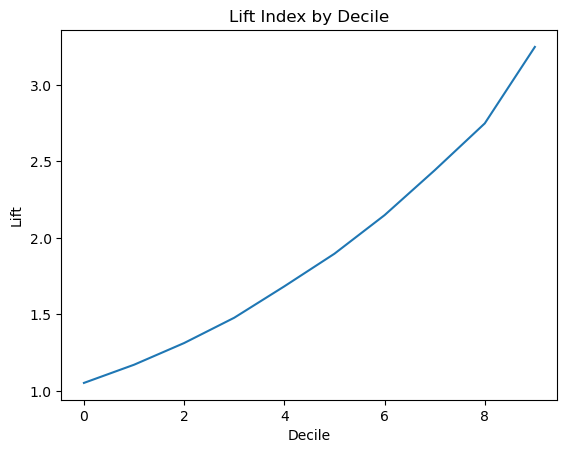

Top-Decile Lift: 3.0182225011146526
Lift Index: 1.9180091422823566
Lift for each decile:
decile
0    1.051815
1    1.170724
2    1.312597
3    1.478022
4    1.683318
5    1.896490
6    2.148504
7    2.441842
8    2.748402
9    3.248378
Name: lift, dtype: float64


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def test():
    # Predict probabilities
    clf = grid_results['ebm']['eprofits']['_best']
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    # Create a DataFrame with true labels and predicted probabilities
    df_lift = pd.DataFrame({'true_labels': y_test, 'pred_probs': y_probs})
    
    # Sort the DataFrame by predicted probabilities in descending order
    df_lift = df_lift.sort_values(by='pred_probs', ascending=False)
    print(df_lift.shape)
    # display(df_lift.head(n=150))
    
    # Calculate the overall churn rate
    overall_churn_rate = df_lift['true_labels'].mean()
    
    # Top-Decile Lift calculation
    top_decile = df_lift.head(int(len(df_lift) * 0.1))
    top_decile_lift = top_decile['true_labels'].mean() / overall_churn_rate

    print(top_decile_lift)
    
    # Divide the data into deciles
    df_lift['decile'] = pd.qcut(df_lift['pred_probs'].rank(method='first'), 10, labels=False) # first decile is actually the last one
    deciles_churners = df_lift.groupby('decile')['true_labels'].sum().to_frame()
    deciles_churners['weight'] = np.arange(0.1, 1.1, 0.1) # first decile is actually the last one
    deciles_churners['w_churners'] = deciles_churners['weight'] * deciles_churners['true_labels']
    print('Lift Index', deciles_churners['w_churners'].sum()/deciles_churners['true_labels'].sum())
    display(deciles_churners)
    
    
    # Calculate the cumulative churn rate for each decile
    df_lift['cumulative_churn'] = df_lift['true_labels'].cumsum() / (np.arange(len(df_lift)) + 1)
    
    # Calculate the Lift for each decile
    df_lift['lift'] = df_lift['cumulative_churn'] / overall_churn_rate
    
    # Calculate the average Lift for each decile
    lift_deciles = df_lift.groupby('decile')['lift'].mean()
    
    # Lift Index calculation
    lift_index = lift_deciles.mean()
    
    # Plot the Lift Index
    plt.plot(lift_deciles)
    plt.xlabel('Decile')
    plt.ylabel('Lift')
    plt.title('Lift Index by Decile')
    plt.show()
    
    # Print Top-Decile Lift, Lift Index, and Lift
    print(f'Top-Decile Lift: {top_decile_lift}')
    print(f'Lift Index: {lift_index}')
    print('Lift for each decile:')
    print(lift_deciles)

test()

via eprofits


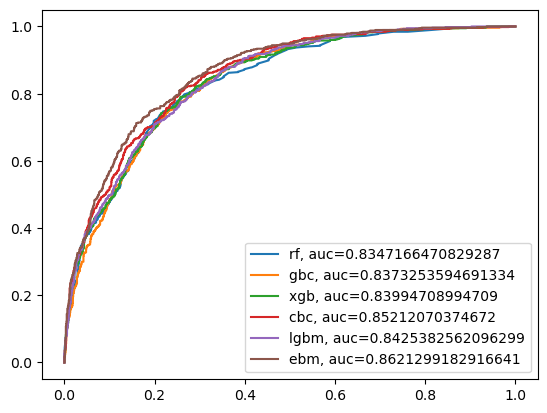

In [66]:
import matplotlib.pyplot as plt


def test_roc(sc_policy):
    y_true = y_test # ground truth labels
    print('via', sc_policy)
    for clf, name, no_df in get_models(grid_results, sc_policy):
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        y_scores = clf.predict_proba(x_te)[:, 1]

    
    
    
        y_probas = y_scores # predicted probabilities generated by sklearn classifier
        fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
        auc = metrics.roc_auc_score(y_true, y_probas)
        plt.plot(fpr,tpr,label= name + ", auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

test_roc('eprofits')

In [67]:
x_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customer_value
1695,1,0,1,1,54,1,1,0,0,1,0,1,1,0,1,1,2,70.70,3770.00,3888.50
1095,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,2,80.55,80.55,161.10
3889,1,0,0,0,13,1,0,2,0,0,0,0,0,0,1,0,1,19.30,259.65,270.20
3667,0,1,1,1,24,1,0,1,0,0,1,0,1,1,2,1,2,96.55,2263.45,2413.75
2902,0,1,0,0,6,1,0,1,1,0,0,0,0,0,0,1,2,74.10,450.90,518.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,0,1,0,1,1,0,1,1,0,0,0,1,1,0,1,2,95.00,95.00,190.00
5191,0,0,1,1,23,1,1,0,1,1,1,1,1,1,2,1,1,91.10,2198.30,2186.40
5226,1,0,1,1,12,1,0,2,0,0,0,0,0,0,0,1,2,21.15,306.05,274.95
5390,1,1,0,0,12,1,1,1,0,0,1,0,1,1,0,1,2,99.45,1200.15,1292.85


In [68]:
grid_results['ebm']['eprofits']['_best']

ExplainableBoostingClassifier(interactions=20, learning_rate=0.1, max_bins=128,
                              max_interaction_bins=32)

In [69]:

def test_grid():
    # Profit_Margin = 0.3
    # Cost_of_Contact = (0, 0.3)
    # CPO = 0.1
    # def custom_eprofits_function(df, Profit_Margin, Cost_of_Contact, CPO):
    #     def custom_scorer(y_true, y_pred):
    #         my_df = df.loc[y_true.index]
    #         my_df['true'] = y_true
    #         my_df['predict'] = y_pred
    #         return _eprofits(my_df, Profit_Margin, Cost_of_Contact, CPO)
    #     return metrics.make_scorer(custom_scorer, greater_is_better=True)

    # df_profit_scorer = pd.DataFrame({'customer_value': x_train['customer_value'], 'retention_rate': x_train[tenure_column].apply(retention_fn)})
    # profit_scorer = custom_eprofits_function(df_profit_scorer, Profit_Margin, Cost_of_Contact, CPO)

    # Define the custom scorer function
    def emp_scorer(estimator, X, y):
        # Use the model to predict probabilities
        y_proba = estimator.predict_proba(X)[:, 1]  # Assuming binary classification and taking the probability of class 1
        return empChurn(y_proba, y, alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
    
    # Create the custom scorer using make_scorer
    custom_emp_function = metrics.make_scorer(emp_scorer, greater_is_better=True, needs_proba=True)
    
    scoring = {
        # 'AUC': metrics.make_scorer(metrics.roc_auc_score),
        # 'accuracy': metrics.make_scorer(metrics.accuracy_score),
        # 'f1': metrics.make_scorer(metrics.f1_score),
        # 'emp': emp_scorer,
        'emp': custom_emp_function,
        # 'profit': profit_scorer
    }
    
    _xgb = xgb.XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
    clf, param_grid = _xgb, param_grid_xgb
    refit = list(scoring.keys())[0]
    if refit == 'emp':
        n_jobs = 1
    else:
        n_jobs = -1
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=scoring, refit=refit, n_jobs=n_jobs, verbose=1)  # n_jobs=-1 is a bit buggy
    grid_search.fit(x_train.iloc[:], y_train.iloc[:])

    my_x_test = x_test.iloc[:]
    my_y_test = y_test.iloc[:]
    # Evaluate the best CBC model
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(my_x_test)
    y_prob = best_clf.predict_proba(my_x_test)[:, 1]
    roc_auc = metrics.roc_auc_score(my_y_test, y_prob)
    clf = best_clf
    
    print(f'Best AUC: {roc_auc}')
    my_df = pd.DataFrame({'customer_value': my_x_test['customer_value'], 'retention_rate': my_x_test[tenure_column].apply(retention_fn), 'true': my_y_test, 'predict': y_pred})
    print('Profit', _eprofits(my_df, Profit_Margin=Profit_Margin, Cost_of_Contact= Cost_of_Contact, CPO=0.1, verbose=0))
    # print(best_clf)
    print(metrics.classification_report(my_y_test, y_pred))
    cm = metrics.confusion_matrix(my_y_test, y_pred, labels=clf.classes_)
    print(cm)
    # disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
    #                           display_labels=clf.classes_)
    # disp.plot()
    # plt.show()
    

test_grid()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best AUC: 0.8554256010396362
Profit 53260.919208618296
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1539
           1       0.88      0.11      0.20       574

    accuracy                           0.75      2113
   macro avg       0.81      0.55      0.53      2113
weighted avg       0.78      0.75      0.68      2113

[[1530    9]
 [ 510   64]]
